Check the large scale galaxy bias as implied by the HOD models we use for each source and lens sample.

In [1]:
# Import modules
% matplotlib inline
import numpy as np; 
import scipy.integrate; 
import scipy.interpolate; 
import matplotlib.pyplot as plt
import pyccl as ccl; 
import shared_functions_wlp_wls as shared; 
import shared_functions_setup as setup

/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/halo_table_cache.py:12: UserWarning: Some of the functionality of the HaloTableCache classrequires h5py to be installed.
  warn("Some of the functionality of the HaloTableCache class"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/user_supplied_ptcl_catalog.py:13: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Most of the functionality of the sim_manager "
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/download_manager.py:39: UserWarning: Some of the functionality of the DownloadManager requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Some of the functionality of the DownloadManager requires h5py to be installed,\n"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/cached_halo_catalog.py:15: UserWarning: Most of the functionality of the

In [2]:
# Set the survey
survey = 'SDSS'
if (survey == 'SDSS'):
    import params as pa
elif (survey == 'LSST_DESI'):
    import params_LSST_DESI as pa

In [3]:
#Initialize the cosmology
OmM = pa.OmC_l + pa.OmB_l; OmB=pa.OmB_l; h0 = pa.HH0_l / 100.; sigma80=pa.sigma8_l; n_s0 = pa.n_s_l;

p = ccl.Parameters(Omega_c = OmM-OmB, Omega_b = OmB, h = h0, sigma8=sigma80, n_s=n_s0)
cosmo = ccl.Cosmology(p)

rho_crit = 3. * 10**10 * pa.mperMpc / (8. * np.pi * pa.Gnewt * pa.Msun)  # Msol h^2 / Mpc^3, for use with M in Msol / h (comoving distances)
rho_m = (OmM) * rho_crit # units of Msol h^2 / Mpc^3 (comoving distances)

In [4]:
# Get the window function of sources x lenses (this is the redshift range we care about)
#(z, dNdz) = shared.window(survey)    

# At the moment get the window function of just lenses
z = np.linspace(pa.zLmin, pa.zLmax, 100)
dNdz = setup.get_dNdzL(z, survey)

In [5]:
logkmin = -6; kpts =40000; logkmax = 5; 
kvec_FT = np.logspace(logkmin, logkmax, kpts)
# Actually we will use a downsampled version of this:
k = np.logspace(np.log10(kvec_FT[0]), np.log10(kvec_FT[-1]), 40)

In [6]:
# Let the galaxy-galaxy two-halo term be given by halofit * bias**2

# DON'T FORGET that CCL power spectra are not in little h units. P(k) has units Mpc^3, takes k in units 1/Mpc

Pknonlin = np.zeros((len(k), len(z)))
#Pklin = np.zeros((len(k), len(z)))
for zi in range(0,len(z)):
    # Change k and Pk to little h units
    Pknonlin[:, zi] = ccl.power.nonlin_matter_power(cosmo, k * h0, 1. / (1. + z[zi])) * h0**3
    #Pklin[:, zi] = ccl.power.linear_matter_power(cosmo, k * h0, 1. / (1. + z[zi])) * h0**3
    
Pkgg = pa.bd*pa.bd * Pknonlin
#Pkgg_lin = pa.bd * pa.bd * Pklin

# Integrate over z
P_2h_gg_avgz = np.zeros(len(k))
#P_2h_gg_avgz_lin = np.zeros(len(k))
for ki in range(0,len(k)):
    P_2h_gg_avgz[ki] = scipy.integrate.simps(dNdz * Pkgg[ki,:], z)
    #P_2h_gg_avgz_lin[ki] = scipy.integrate.simps(dNdz * Pkgg_lin[ki,:], z)

In [7]:
# Use the longer k vector to Fourier transform

interp_in_k = scipy.interpolate.interp1d(np.log(k), np.log(P_2h_gg_avgz))
twoh_Pgg_klong = np.exp(interp_in_k(np.log(kvec_FT)))

savePgg = np.column_stack((kvec_FT, twoh_Pgg_klong))
np.savetxt('./txtfiles/halofit_Pk/Pk_2h_SDSS_lens_nonlin_fixhunits.txt', savePgg)      

In [8]:
# Load  the combined xi from file after Fourier transforming

(r, xi_tot) = np.loadtxt('./txtfiles/halofit_xi/xi_2h_SDSS_lens_nonlin_fixhunits.txt', unpack=True)

#plt.figure(figsize=[10,10])
#plt.loglog(r, xi_tot, 'm', label='1h+2h')
#plt.ylabel('$\\xi(r)$')
#plt.xlabel('$r$, Mpc/h')
#plt.xlim(0.01, 100)
#plt.ylim(0.001, 10**6)
#plt.title('$\\xi(r)$, SDSS')
#plt.legend()
#plt.show()
#plt.savefig('./plots/xi_SDSS.png')

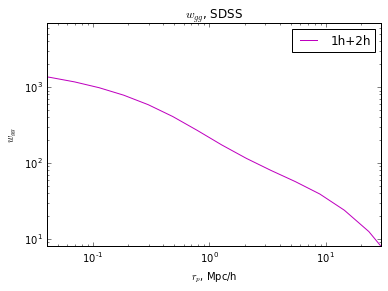

In [9]:
# Project:

for ri in range(0,len(r)):
    if xi_tot[ri]<10**(-12):
        xi_tot[ri]=10**(-12)

#interpolate in r:
interp_xi = scipy.interpolate.interp1d(np.log(r), np.log(xi_tot))

rp = np.logspace(-2, 2, 20)
Pi = np.logspace(-5, np.log10(80.), 1000) # use the same projection length as Reid & Spergel 2008

logxi_2d = np.zeros((len(rp), len(Pi)))
for ri in range(0,len(rp)):
    for pi in range(0,len(Pi)):
        r_2d = np.sqrt( rp[ri]**2 + Pi[pi]**2 )
        logxi_2d[ri, pi] = interp_xi(np.log(r_2d))

wgg = [0]*len(rp)
for ri in range(0,len(rp)):
   # print np.log(np.sqrt(rp[ri]**2 + Pi**2))
    wgg[ri] = 2.*scipy.integrate.simps(np.exp(logxi_2d[ri,:]), Pi)
    
plt.figure()
plt.loglog(rp, np.asarray(wgg), 'm', label='1h+2h')
plt.ylabel('$w_{gg}$')
plt.xlabel('$r_p$, Mpc/h')
plt.title('$w_{gg}$, SDSS')
plt.xlim(0.04, 30)
plt.ylim(8, 7000)
plt.legend()
#plt.show()
plt.savefig('./plots/wgg_SDSS.pdf')

In [ ]:
#